In [1]:
import pylab
import calendar
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt

In [2]:
products = pd.read_csv('products.csv')
aisles = pd.read_csv('aisles.csv')
departments = pd.read_csv('departments.csv')
order_products_train = pd.read_csv('order_products__train.csv')
order_products_prior = pd.read_csv('order_products__prior.csv')
orders = pd.read_csv('orders.csv')

In [3]:
aisles.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [5]:
products.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [6]:
products['product_name'].nunique()

49688

In [7]:
departments.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [8]:
order_products_train.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [9]:
order_products_prior.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [10]:
total = orders.isnull().sum().sort_values(ascending=False)
total
percent = (orders.isnull().sum()/orders.isnull().count()).sort_values(ascending=False)
percent
missing_data = pd.concat([total, percent], axis=1, keys=['Total Missing', 'Percent'])
missing_data

,Total Missing,Percent
days_since_prior_order,206209,0.060276
order_hour_of_day,0,0.000000
order_dow,0,0.000000
order_number,0,0.000000
eval_set,0,0.000000
user_id,0,0.000000
order_id,0,0.000000


In [11]:
orders1= orders
orders1['days_since_prior_order']=orders1['days_since_prior_order'].fillna(orders1['days_since_prior_order'].mean())
orders1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3421083 entries, 0 to 3421082
Data columns (total 7 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   order_id                int64  
 1   user_id                 int64  
 2   eval_set                object 
 3   order_number            int64  
 4   order_dow               int64  
 5   order_hour_of_day       int64  
 6   days_since_prior_order  float64
dtypes: float64(1), int64(5), object(1)
memory usage: 182.7+ MB


[Text(0.5, 0, 'Hour Of The Day'),
 Text(0.5, 1.0, 'Order Count Across Hour Of The Day')]

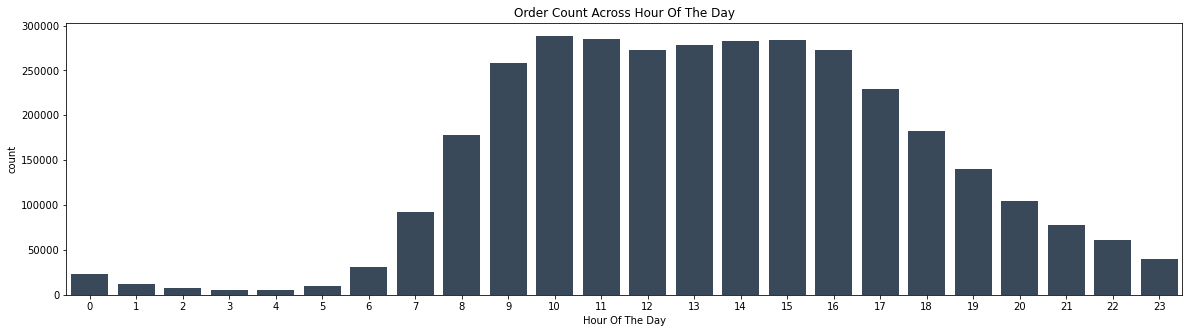

In [12]:
#When Do People Generally Order?
fig,ax = plt.subplots()
fig.set_size_inches(20,5)
sns.countplot(data=orders1,x="order_hour_of_day",ax=ax,color="#34495e")
ax.set(xlabel='Hour Of The Day',title="Order Count Across Hour Of The Day")
#People order most between 10 AM to 4 PM

[Text(0.5, 0, 'Day Of The Week'),
 Text(0.5, 1.0, 'Order Count Across Days Of The Week')]

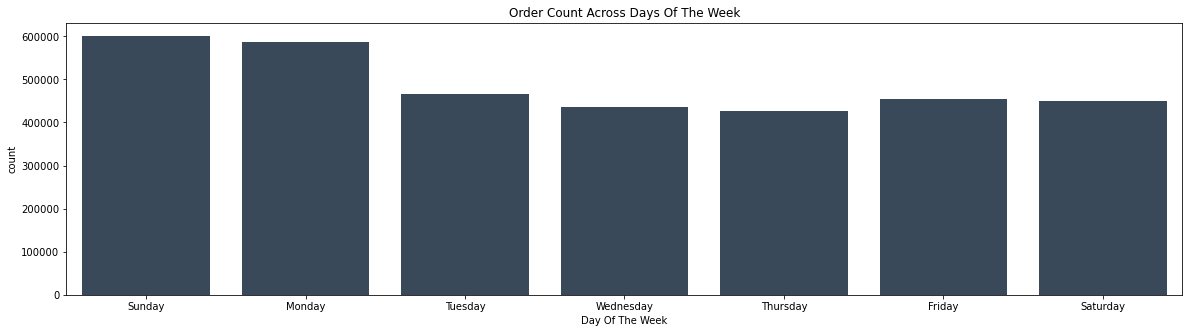

In [13]:
#At What Day Of The Week People Order?
fig,ax = plt.subplots()
fig.set_size_inches(20,5)
ordersDay = orders[["order_dow"]].replace({0:"Sunday",1:"Monday",2:"Tuesday",3:"Wednesday",4:"Thursday",5:"Friday",6:"Saturday"})

sns.countplot(color="#34495e",data=ordersDay,x="order_dow",ax=ax,order=["Sunday","Monday","Tuesday","Wednesday","Thursday","Friday","Saturday"])
ax.set(xlabel='Day Of The Week',title="Order Count Across Days Of The Week")
#People order more on Sunday and Monday

[Text(0.5, 0, 'Order Count'), Text(0.5, 1.0, 'Order Count')]

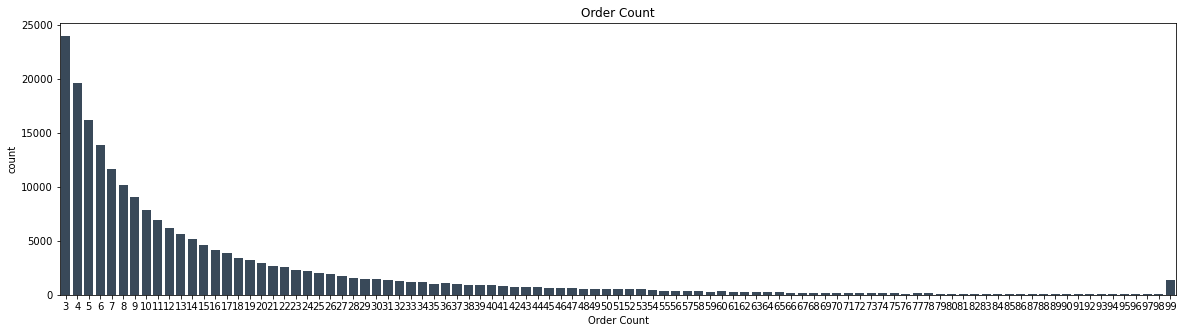

In [15]:
#How many orders users generally made?
orderCount = orders[orders["eval_set"]=="prior"].groupby(by=["user_id"])["order_id"].count().to_frame()
fig,ax = plt.subplots()
fig.set_size_inches(20,5)
sns.countplot(color="#34495e",data=orderCount,x="order_id",ax=ax)
ax.set(xlabel='Order Count',title="Order Count")
#People generally make 3 to 10 orders

,product_id,count,product_name,aisle_id,department_id
0,24852,18726,Banana,24,4
1,13176,15480,Bag of Organic Bananas,24,4
2,21137,10894,Organic Strawberries,24,4
3,21903,9784,Organic Baby Spinach,123,4
4,47626,8135,Large Lemon,24,4
5,47766,7409,Organic Avocado,24,4
6,47209,7293,Organic Hass Avocado,24,4
7,16797,6494,Strawberries,24,4
8,26209,6033,Limes,24,4
9,27966,5546,Organic Raspberries,123,4


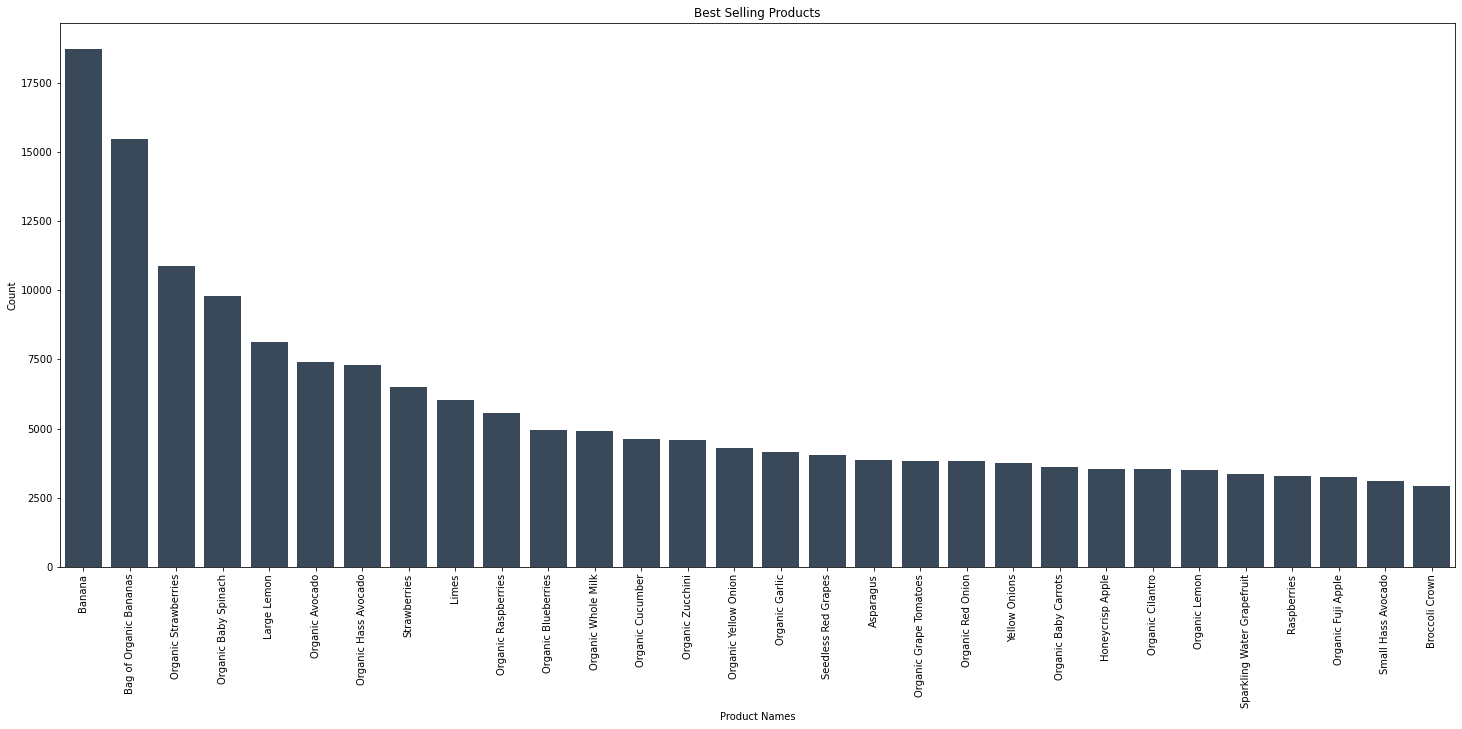

In [16]:
#Best Selling Products
productsCount = order_products_train["product_id"].value_counts().to_frame()
productsCount["count"] = productsCount.product_id
productsCount["product_id"] = productsCount.index
mergedData = pd.merge(productsCount,products,how="left",on="product_id").sort_values(by="count",ascending=False)

fig,ax = plt.subplots()
fig.set_size_inches(25,10)
sns.barplot(data=mergedData.head(30),x="product_name",y="count",ax=ax,orient="v",color="#34495e")
ax.set(xlabel='Product Names',ylabel="Count",title="Best Selling Products")
plt.xticks(rotation=90)

mergedData.head(10)

In [18]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from sklearn.decomposition import PCA

In [19]:
order_products = order_products_prior.merge(products, on ='product_id', how='left')
order_products = order_products.merge(aisles, on ='aisle_id', how='left')
order_products = order_products.merge(departments, on ='department_id', how='left')
order_products = order_products.merge(orders, on='order_id', how='left')
order_products.shape

(32434489, 15)

In [20]:
cross_df = pd.crosstab(order_products.user_id, order_products.aisle)
cross_df.head()

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
2,0,3,0,0,0,0,2,0,0,0,...,3,1,1,0,0,0,0,2,0,42
3,0,0,0,0,0,0,0,0,0,0,...,4,1,0,0,0,0,0,2,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
5,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3


In [21]:
df = cross_df.div(cross_df.sum(axis=1), axis=0)
df.head()

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.016949,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.016949
2,0.0,0.015385,0.0,0.0,0.0,0.0,0.010256,0.0,0.0,0.0,...,0.015385,0.005128,0.005128,0.000000,0.0,0.0,0.0,0.010256,0.0,0.215385
3,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.045455,0.011364,0.000000,0.000000,0.0,0.0,0.0,0.022727,0.0,0.000000
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.055556,0.0,0.0,0.0,0.055556,0.0,0.000000
5,0.0,0.054054,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.081081


In [22]:
pca = PCA(n_components=10)
df_pca = pca.fit_transform(df)
df_pca = pd.DataFrame(df_pca)
df_pca.head()

,0,1,2,3,4,5,6,7,8,9
0,-0.113443,0.039084,-0.042863,0.018865,-0.088340,-0.104547,-0.116442,0.083721,-0.063229,-0.025670
1,-0.036988,0.108884,-0.066406,-0.123270,0.098849,-0.033952,-0.054727,-0.053352,-0.020305,-0.008029
2,0.064282,0.103962,0.000710,-0.012220,-0.046983,0.112242,-0.029803,0.007908,0.012031,0.002404
3,-0.093210,0.054093,0.001867,-0.003974,-0.071358,-0.019280,-0.025118,-0.038251,0.006481,-0.000934
4,0.094629,-0.037051,-0.024952,-0.021574,0.055369,0.107649,-0.008036,0.103945,0.051619,-0.025682


In [23]:
Sum_of_squared_distances = []
K = range(1,10)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(df_pca)
    Sum_of_squared_distances.append(km.inertia_)

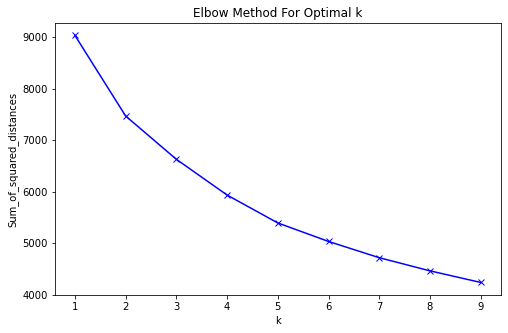

In [24]:
plt.subplots(figsize = (8, 5))
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [25]:
cluster_ = KMeans(n_clusters=5,random_state=42).fit(df_pca)
centers = cluster_.cluster_centers_
c_preds = cluster_.predict(df_pca)
print(centers)

[[ 6.75098865e-02  1.05713264e-01 -1.14502028e-03 -3.09369888e-02
  -1.07023506e-02  7.22766430e-03 -5.19787210e-04  4.51652787e-03
  -7.14078180e-04 -1.60470249e-04]
 [-1.98201878e-01  1.61379565e-02  3.16916629e-01 -3.13693186e-02
   1.86339422e-02  5.64327045e-04  4.00964425e-03  1.09250380e-02
   1.23024114e-03 -3.84012779e-03]
 [-7.39220810e-02 -1.06013694e-02 -2.70272727e-02 -6.98749025e-03
  -6.75956067e-03  1.54267484e-03  5.07322567e-04 -2.53861963e-03
  -3.26504973e-04 -4.09356935e-04]
 [ 1.05576711e-01 -7.31240628e-02  1.72645913e-02  3.68234196e-03
   1.77182174e-03 -4.44689672e-03 -9.47565055e-04  1.29273522e-03
  -1.69430453e-04  7.74320671e-04]
 [-6.10674546e-03  1.30773012e-01  4.87142579e-03  2.30158478e-01
   1.10140384e-01 -2.28465570e-02  6.82635069e-05 -6.41051643e-03
   7.82512195e-03  3.05362514e-03]]


In [26]:
temp_df = df_pca.iloc[:, 0:2]
temp_df.columns = ["pc1", "pc2"]
temp_df['cluster'] = c_preds
temp_df.head()

<ipython-input-26-dd20da319cba>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['cluster'] = c_preds


,pc1,pc2,cluster
0,-0.113443,0.039084,2
1,-0.036988,0.108884,0
2,0.064282,0.103962,0
3,-0.093210,0.054093,2
4,0.094629,-0.037051,3


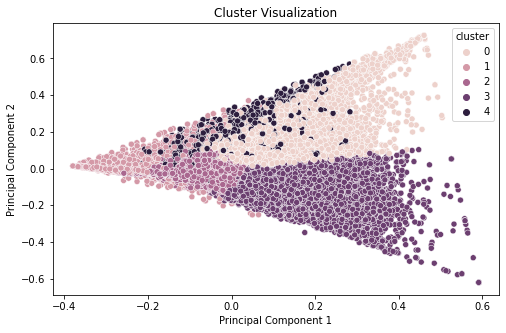

In [27]:
fig, ax = plt.subplots(figsize = (8, 5))
ax = sns.scatterplot(data = temp_df, x = "pc1", y = "pc2", hue = "cluster")
ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
ax.set_title("Cluster Visualization")
plt.show();

In [28]:
#Top products per cluster
cross_df['cluster'] = c_preds

cluster1 = cross_df[cross_df.cluster == 0]
cluster2 = cross_df[cross_df.cluster == 1]
cluster3 = cross_df[cross_df.cluster == 2]
cluster4 = cross_df[cross_df.cluster == 3]
cluster5 = cross_df[cross_df.cluster == 4]

In [29]:
cluster1.drop('cluster',axis=1).mean().sort_values(ascending=False)[0:10]

aisle
fresh fruits                     35.757686
fresh vegetables                 15.045879
packaged vegetables fruits       12.103781
yogurt                            9.895322
milk                              5.961399
packaged cheese                   5.115224
soy lactosefree                   3.779887
water seltzer sparkling water     3.613036
bread                             3.198307
chips pretzels                    3.134604
dtype: float64

In [30]:
cluster1.drop('cluster',axis=1).mean().sort_values(ascending=False)[0:10]

aisle
fresh fruits                     35.757686
fresh vegetables                 15.045879
packaged vegetables fruits       12.103781
yogurt                            9.895322
milk                              5.961399
packaged cheese                   5.115224
soy lactosefree                   3.779887
water seltzer sparkling water     3.613036
bread                             3.198307
chips pretzels                    3.134604
dtype: float64

In [31]:
cluster2.shape

(5417, 135)

In [32]:
cluster2.drop('cluster',axis=1).mean().sort_values(ascending=False)[0:10]

aisle
water seltzer sparkling water    20.946834
fresh fruits                      3.335979
soft drinks                       2.803397
yogurt                            2.255307
energy granola bars               1.556766
chips pretzels                    1.346686
tea                               1.329887
milk                              1.326749
packaged vegetables fruits        1.251061
soy lactosefree                   1.082518
dtype: float64

In [33]:
cluster3.shape

(99117, 135)

In [34]:
cluster3.drop('cluster',axis=1).mean().sort_values(ascending=False)[0:10]

aisle
fresh fruits                     9.767164
fresh vegetables                 7.571506
yogurt                           7.217632
packaged vegetables fruits       5.999556
packaged cheese                  4.931334
chips pretzels                   4.480795
milk                             4.252722
water seltzer sparkling water    4.091195
refrigerated                     3.257504
ice cream ice                    3.097864
dtype: float64

In [35]:
cluster4.shape

(55801, 135)

In [36]:
cluster4.drop('cluster',axis=1).mean().sort_values(ascending=False)[0:10]

aisle
fresh vegetables                 37.044300
fresh fruits                     21.745578
packaged vegetables fruits       12.027186
yogurt                            6.159639
packaged cheese                   5.018996
fresh herbs                       4.151592
milk                              4.003118
soy lactosefree                   3.704844
frozen produce                    3.302073
water seltzer sparkling water     3.080626
dtype: float64

In [37]:
cluster5.shape

(7948, 135)

In [38]:
cluster5.drop('cluster',axis=1).mean().sort_values(ascending=False)[0:10]

aisle
packaged produce                 18.354051
fresh fruits                     10.877453
packaged vegetables fruits        4.240186
fresh vegetables                  3.105813
water seltzer sparkling water     1.714519
milk                              1.615627
packaged cheese                   1.544162
frozen produce                    1.144942
chips pretzels                    1.139155
nuts seeds dried fruit            1.033090
dtype: float64

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mlxtend.frequent_patterns import apriori,association_rules
import zipfile

import os

In [40]:
data = pd.merge(order_products_prior,products,how='inner',on='product_id')
data.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id
0,2,33120,1,1,Organic Egg Whites,86,16
1,26,33120,5,0,Organic Egg Whites,86,16
2,120,33120,13,0,Organic Egg Whites,86,16
3,327,33120,5,1,Organic Egg Whites,86,16
4,390,33120,28,1,Organic Egg Whites,86,16


In [41]:
data = data[data['order_id']<10000]

In [42]:
data

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id
0,2,33120,1,1,Organic Egg Whites,86,16
1,26,33120,5,0,Organic Egg Whites,86,16
2,120,33120,13,0,Organic Egg Whites,86,16
3,327,33120,5,1,Organic Egg Whites,86,16
4,390,33120,28,1,Organic Egg Whites,86,16
...,...,...,...,...,...,...,...
30093387,9992,7494,3,1,0% Fat Black Cherry Greek Yogurt y,120,16
30093511,9994,21645,9,1,Apple & Cinnamon Adjustable Air Freshener,101,17
30093699,9995,3883,10,1,Chicken Fingers,34,1
30093795,9995,45240,20,1,"Sausages, Little Pork",52,1


In [43]:
data.shape


(94482, 7)

In [44]:
df_item = data[['order_id','product_name']].copy()
df_item.rename(columns={'order_id':'order','product_name':'items'},inplace=True)
df_item['temp']=1

In [45]:
df = df_item.groupby(['order','items'])['temp'].sum().unstack().fillna(0)

In [46]:
df_item

,order,items,temp
0,2,Organic Egg Whites,1
1,26,Organic Egg Whites,1
2,120,Organic Egg Whites,1
3,327,Organic Egg Whites,1
4,390,Organic Egg Whites,1
...,...,...,...
30093387,9992,0% Fat Black Cherry Greek Yogurt y,1
30093511,9994,Apple & Cinnamon Adjustable Air Freshener,1
30093699,9995,Chicken Fingers,1
30093795,9995,"Sausages, Little Pork",1


In [47]:
freq_itemsets = apriori(df,min_support=0.01,use_colnames=True)
freq_itemsets

,support,itemsets
0,0.012304,(100% Raw Coconut Water)
1,0.018456,(100% Whole Wheat Bread)
2,0.012410,(2% Reduced Fat Milk)
3,0.026517,(Apple Honeycrisp Organic)
4,0.019092,(Asparagus)
...,...,...
110,0.018562,"(Banana, Organic Strawberries)"
111,0.013577,"(Banana, Strawberries)"
112,0.012516,"(Organic Strawberries, Organic Baby Spinach)"
113,0.011773,"(Organic Hass Avocado, Organic Strawberries)"


In [48]:
rules = association_rules(freq_itemsets,metric='lift',min_threshold=1)
rules.sort_values(by='confidence',ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
8,(Honeycrisp Apple),(Banana),0.026411,0.149130,0.010182,0.385542,2.585271,0.006244,1.384749
14,(Organic Fuji Apple),(Banana),0.028214,0.149130,0.010395,0.368421,2.470465,0.006187,1.347210
5,(Organic Raspberries),(Bag of Organic Bananas),0.043063,0.120598,0.012940,0.300493,2.491684,0.007747,1.257173
2,(Organic Hass Avocado),(Bag of Organic Bananas),0.064807,0.120598,0.019304,0.297872,2.469956,0.011489,1.252481
21,(Strawberries),(Banana),0.045609,0.149130,0.013577,0.297674,1.996070,0.006775,1.211503
11,(Organic Avocado),(Banana),0.055579,0.149130,0.015592,0.280534,1.881136,0.007303,1.182641
27,(Organic Raspberries),(Organic Strawberries),0.043063,0.079338,0.010076,0.233990,2.949277,0.006660,1.201893
19,(Organic Strawberries),(Banana),0.079338,0.149130,0.018562,0.233957,1.568811,0.006730,1.110734
0,(Organic Baby Spinach),(Bag of Organic Bananas),0.072762,0.120598,0.015804,0.217201,1.801031,0.007029,1.123407
6,(Organic Strawberries),(Bag of Organic Bananas),0.079338,0.120598,0.017183,0.216578,1.795860,0.007615,1.122513


In [49]:
rules[(rules['confidence']>0.16) & (rules['lift']>2)]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
2,(Organic Hass Avocado),(Bag of Organic Bananas),0.064807,0.120598,0.019304,0.297872,2.469956,0.011489,1.252481
3,(Bag of Organic Bananas),(Organic Hass Avocado),0.120598,0.064807,0.019304,0.160070,2.469956,0.011489,1.113418
5,(Organic Raspberries),(Bag of Organic Bananas),0.043063,0.120598,0.012940,0.300493,2.491684,0.007747,1.257173
8,(Honeycrisp Apple),(Banana),0.026411,0.149130,0.010182,0.385542,2.585271,0.006244,1.384749
14,(Organic Fuji Apple),(Banana),0.028214,0.149130,0.010395,0.368421,2.470465,0.006187,1.347210
23,(Organic Baby Spinach),(Organic Strawberries),0.072762,0.079338,0.012516,0.172012,2.168083,0.006743,1.111926
24,(Organic Hass Avocado),(Organic Strawberries),0.064807,0.079338,0.011773,0.181669,2.289812,0.006632,1.125049
27,(Organic Raspberries),(Organic Strawberries),0.043063,0.079338,0.010076,0.233990,2.949277,0.006660,1.201893
